In [1]:
# imports
from tqdm import tqdm # progressbar
import os
import numpy as np
from astropy.stats import mad_std
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data and generate a matrix of observations
#path = 'D:/McDonald backups/results_M11_Sept20_2'
path = 'D:/McDonald backups/results_M11_Sept19_AGtest'

files = [f for d, s, f in os.walk(path)][0]

# order the files
phot_files = []
seq_files = []
batch_ids = np.arange(0, 1000).astype(str)
for b in batch_ids:
    for f in files:
        if 'photometry' in f and 'batch' + b + '.npy' in f:
            phot_files.append(f)
        elif 'seq' in f and 'batch' + b + '.npy' in f:
            seq_files.append(f)

In [3]:
n = 0 # use as reference for array dimensions
fs = np.load(os.path.join(path, phot_files[n])) # use for shape info
data = np.zeros((len(phot_files), fs.shape[0], fs.shape[1])) # data matrix
t = np.zeros((len(seq_files), fs.shape[0])) # observation sequence numbers (i.e. time)

# staple together the data in files
def batch_files(files, arr):
    for i,file in enumerate(files):
        arr[i] = np.load(os.path.join(path, file))
    return arr

data = batch_files(phot_files, data)
t = batch_files(seq_files, t)

In [4]:
# reshape and change dtype
data = data.reshape(data.shape[0] * data.shape[1], data.shape[2]).astype(np.float32)
t = t.flatten().astype(np.int64)
data.shape, data.dtype, t.shape, t.dtype

((280000, 547), dtype('float32'), (280000,), dtype('int64'))

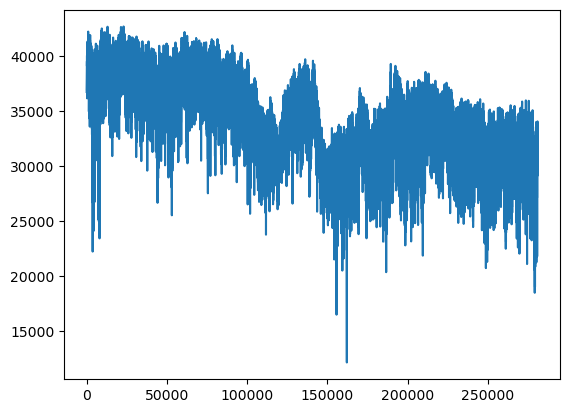

In [5]:
plt.plot(t, data[:,0]);

In [13]:
N = 500 # batch split
batch_grid = np.arange(0, data.shape[0], N)

burn_in = 5 # how many batches to consider before switching the scene (establish baseline flux)
consecutive = 3 # how many consecutive batches show significant change from baseline before making a switch
scene_change_threshold = 10 # signifance of change

# 10 brightest sources
sources = np.arange(0, 1)
for source in sources:
    med_fluxes = [] # list of historical fluxes
    candidate_change = [] # candidate change events
    for i,bg in enumerate(batch_grid):
        batch = data[:,source][bg:bg+N]
        med_flux = np.median(batch) # med batch flux

        # compare med_flux to historial med fluxes
        med_flux_hist = np.median(med_fluxes) # historical median
        flux_std = mad_std(med_fluxes) # MAD


        if len(med_fluxes) > burn_in:
            if med_flux < (med_flux_hist - scene_change_threshold * flux_std) or med_flux > (med_flux_hist + scene_change_threshold * flux_std):
                candidate_change.append(i)
                # consistent deviation from baseline?
                if len(candidate_change) >= consecutive and ((candidate_change[-1] - candidate_change[-consecutive]) == consecutive - 1) == True:
                    print('New scene???', i, source)
                    print(med_flux, med_flux_hist - scene_change_threshold * flux_std, med_flux_hist + scene_change_threshold * flux_std)

        # add med to list of historical med fluxes
        med_fluxes.append(med_flux) 
        
    #plt.scatter(batch_grid, med_fluxes)
    #plt.show()



In [14]:
2500 / 90

27.77777777777778